In [ ]:
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns

from sklearn import linear_model
from sklearn import metrics
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [ ]:
#USEFUL FUNCTIONS FOR PLOTTING

def plot_cdf(data, votes, bin_edges, ax, xlabel=None, color=None):

    '''
    This function is useful to understand whether in inout feature "data" there is information which is correlated to the
    satisfaction of the users.
    Generally speaking, the meaning of the CDFs is that, if there is a gap between the distributions of the data
    conditioned to the satisfaction class of the corresponding users, it means that the information in the data is
    correlated to users satisfaction and thus can be learnt by a supervised classifier.
    Generally speaking, looking at data distributions is the first step to decide whether some data may be useful or
    not for ML problems.
    :param data: data to be plot (one-dimensional array)
    :param votes: satisfaction labels, int; if already binary, set threshold to None
    :param bin_edges: array of type  np.linspace(min(data), max(data), num_bins+1)
    :param ax: axis of type plt.subplots(figsize=(a,b));
    :param xlabel: label to gice to x axis
    :param color: axis color
    :return:
    '''

    if xlabel is None:
        xlabel = 'your data'
    if color is None:
        color = 'black'

    yt = votes.copy()

    neg, _ = np.histogram(data[yt == +1], bins=bin_edges)  # count number of evidences per bin
    pos, _ = np.histogram(data[yt == 0], bins=bin_edges)

    sumpos =  sum(pos)
    sumneg =  sum(neg)
    pos = pos.astype(float) / sumpos  # normalize to total number of evidences
    neg = neg.astype(float) / sumneg

    xrange = bin_edges[1:] - bin_edges[:1]

    title = 'CDF'
    ax.plot(xrange, np.cumsum(pos))
    ax.plot(xrange, np.cumsum(neg))
    ax.xaxis.label.set_color(color)
    ax.yaxis.label.set_color(color)
    ax.tick_params(axis='x', colors=color)
    ax.tick_params(axis='y', colors=color)
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)
    ax.set_xlabel(xlabel)
    ax.set_title(title, color=color)
    ax.legend(['High QoE', 'Low QoE'])
    return

# USEFUL FUNCTIONS FOR PREDICTION

def hyperparameter_tuning(train_sample, train_target, names, classifiers, parameters_grid,
                          n_splits_in=None, ref_metric=None):
    '''
    This function applies a cross validation strategy to select, for each of the classifiers provided in input,
    the best hyper-parameters (hp) values out of a pool of candidate values (Grid Search Procedure).
    The function saves on a file the best hp values, for the input Training Fold. Finally, it returns the prediction
    performance on the input Validation Fold.
    (ref: https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/)

    :param train_sample: training samples set
    :param train_target: training users satisfaction labels
    :param test_sample: test samples set
    :param test_target: test users satisfaction labels
    :param names: involved classifiers names
    :param classifiers: involved classifiers scikitlearn functions
    :param n_splits_in: number of k fold splits for validation (our results were derived with 10 folds, which is the default value)
    :param ref_metric: optimization metric (sklearn.metrics); default roc_auc
    :return: prediction performance on the test set (AUC)
    '''

    if ref_metric is None:
        ref_metric = 'roc_auc'
    if n_splits_in is None:
        n_splits_in = 2

    best_hp = pd.DataFrame(index = names, columns = ['BestHP_Values'])
    print('Choose Best hyper-parameters through Cross Validation')
    text_file = open('Best_hyper-parameters (HP Tuning).txt', "w") # If this filename already exists in folder,
    # results will be appended to older file. Delete older version to fill a new txt file.
    text_file.write("############\n")
    for name, clf in zip(names, classifiers):
        text_file.write("{}:\n".format(name))
        print("############")
        print(' Classifier {} - Processing'.format(name))
        grid = parameters_grid[names.index(name)] #take hyper-parameters candidate values grid
        estimator = model_selection.GridSearchCV(clf, grid, scoring=ref_metric, refit=True,
                                                 cv=n_splits_in).fit(train_sample, train_target) #Grid Search
        bp = estimator.best_params_
        print(' Best Parameters Values: {}'.format(bp))
        print(list(bp.values()))
        best_hp.at[name,'BestHP_Values'] = list(bp.values())
        text_file.write("{}:\n".format(estimator.best_params_))
        text_file.write("############\n")
        print("############")
    text_file.write("******************\n")
    text_file.close()

    return best_hp


def plot_cf_matrix(train_sample, train_target, test_sample, test_target, predictions, names):
    '''
    Takes as input actual test data and predictions computed against it. Plots heatmap using seaborn with annotated labels.
    Also computes accuracy, precision, recall and F1-score to include in the plot.
    '''
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    fig, ax = plt.subplots(1, 2)
    for idx, clf_pred in enumerate(predictions):
        confusion_matrix = metrics.confusion_matrix(test_target, clf_pred, labels=[0, 1])
        group_counts = ['{0:0.0f}'.format(value) for value in confusion_matrix.flatten()]
        labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_counts)]
        labels = np.asarray(labels).reshape(2,2)
        sns.set(rc = {'figure.figsize':(15,6)})
        sns.heatmap(confusion_matrix, annot=labels, fmt='', cmap='mako', ax=ax[idx])
        accuracy  = np.trace(confusion_matrix) / float(np.sum(confusion_matrix))
        precision = confusion_matrix[1,1] / sum(confusion_matrix[:,1])
        recall = confusion_matrix[1,1] / sum(confusion_matrix[1,:])
        f1_score  = 2*precision*recall / (precision + recall)
        stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(accuracy,precision,recall,f1_score)
        ax[idx].set_title('Confusion Matrix - '+names[idx])
        ax[idx].set_ylabel('True label')
        ax[idx].set_xlabel('Predicted label' + stats_text)
    return


def direct_prediction(train_sample, train_target, test_sample, test_target, names, classifiers):
    '''
    This function takes in input a group of classifiers with already fixed HP values, train them on the input data
    train_sample --> train_target and finally performs prediction on the input test_sample-->test_target.

    Note that each classifier outputs the probability that a given test user belongs to the
    class of Dissatisfied Users. By thresholding such probability, one can effectively assign to the test user
    either the Satisfied ('0') or the Dissatisfied ('1') label. Computing the FPR and TPR of the classifier for
    different threshold values, it is possible to draw a ROC Curve.
    Finally, the performance in terms of Area Under the ROC Curve are returned as output.
    (ref: https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)


    :param train_sample: training samples set
    :param train_target: training users satisfaction labels
    :param test_sample: test samples set
    :param test_target: test users satisfaction labels
    :param names: names of the considered classifiers
    :param classifiers: the scikit methods corresponding to the considered classifiers
    :return: prediction performance (AUC) on the test set
    '''

    perf = pd.DataFrame(index=names,columns=['AUC'])
    prediction_proba = np.empty((len(names), len(test_sample)))

    plt.figure(figsize=(20, 5))
    color = ['b', 'r', 'g', 'c', 'k', 'm'] #choose a color for each classifier
    color = color[:len(names)]
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.3) # ROC Curve of a dummy
    # Classifier
    estimator_pred = [None]*len(names)

    for name, clf in zip(names, classifiers):
        print(' Classifier {} - Fit & Predict'.format(name))
        estimator = clf.fit(train_sample, train_target) # fit the classifier on training set

        prediction_proba[names.index(name),:] = estimator.predict_proba(test_sample)[:, 1] # generate, for each test
        # user, the probability that the user is not satisfied

        fpr, tpr, decision_thresholds = metrics.roc_curve(test_target, prediction_proba[names.index(name),:]
                                                          , pos_label=1)

        perf.at[name,'AUC'] = metrics.auc(fpr, tpr)
        plt.plot(fpr, tpr, color=color[names.index(name)], label=r'ROC %s (AUC = %0.3f)' % (name,perf.loc[name,
                                                                                                          'AUC']), lw=2, alpha=.8)
        perf.at[name,'AUC'] = metrics.auc(fpr, tpr)
        estimator_pred[names.index(name)] = estimator.predict(test_sample)

    plt.plot(0, 1, '*', color='k', label=r'Optimum: FPR = 0, TPR = 1', lw=2, alpha=.8, markersize=15)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xticks(color='black')
    plt.yticks(color='black')
    plt.grid(1)
    plt.xlabel('False Positive Rate', color='black', fontsize=14)
    plt.ylabel('True Positive Rate', color='black', fontsize=14)
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    #plt.savefig('ROC.png', bbox_inches='tight') #uncomment to save the plot
    return perf, estimator_pred

# Import Training Data

In [ ]:
if 'dataset' in globals():
    del dataset
if 'ground_truth' in globals():
    del ground_truth

path = '/content/'
basic_train = pd.read_csv(path+'BasicDataset_Training_MRN.csv')
basic_train.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)

In [ ]:
# Check for null values
basic_train.isna().sum()

Cumulative_YoutubeSess_LTE_DL_Time       0
Cumulative_YoutubeSess_LTE_DL_Volume     0
Cumulative_YoutubeSess_UMTS_DL_Time      0
Cumulative_YoutubeSess_UMTS_DL_Volume    0
Max_RSRQ                                 0
Max_SNR                                  0
User_Satisfaction                        0
Cumulative_Full_Service_Time_UMTS        0
Cumulative_Lim_Service_Time_UMTS         0
Cumulative_No_Service_Time_UMTS          0
Cumulative_Full_Service_Time_LTE         0
Cumulative_Lim_Service_Time_LTE          0
Cumulative_No_Service_Time_LTE           0
dtype: int64

In [ ]:
# Check for count of zero values
for column_name in basic_train.columns:
    column = basic_train[column_name]
    count = (column == 0).sum()
    print('Count of zeros in column ', column_name, ' is : ', count)

Count of zeros in column  Cumulative_YoutubeSess_LTE_DL_Time  is :  1068
Count of zeros in column  Cumulative_YoutubeSess_LTE_DL_Volume  is :  1068
Count of zeros in column  Cumulative_YoutubeSess_UMTS_DL_Time  is :  10992
Count of zeros in column  Cumulative_YoutubeSess_UMTS_DL_Volume  is :  10995
Count of zeros in column  Max_RSRQ  is :  0
Count of zeros in column  Max_SNR  is :  1
Count of zeros in column  User_Satisfaction  is :  12758
Count of zeros in column  Cumulative_Full_Service_Time_UMTS  is :  0
Count of zeros in column  Cumulative_Lim_Service_Time_UMTS  is :  0
Count of zeros in column  Cumulative_No_Service_Time_UMTS  is :  4
Count of zeros in column  Cumulative_Full_Service_Time_LTE  is :  0
Count of zeros in column  Cumulative_Lim_Service_Time_LTE  is :  2
Count of zeros in column  Cumulative_No_Service_Time_LTE  is :  4


# Data Visualization

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcd41293e50>,
      dtype=object)

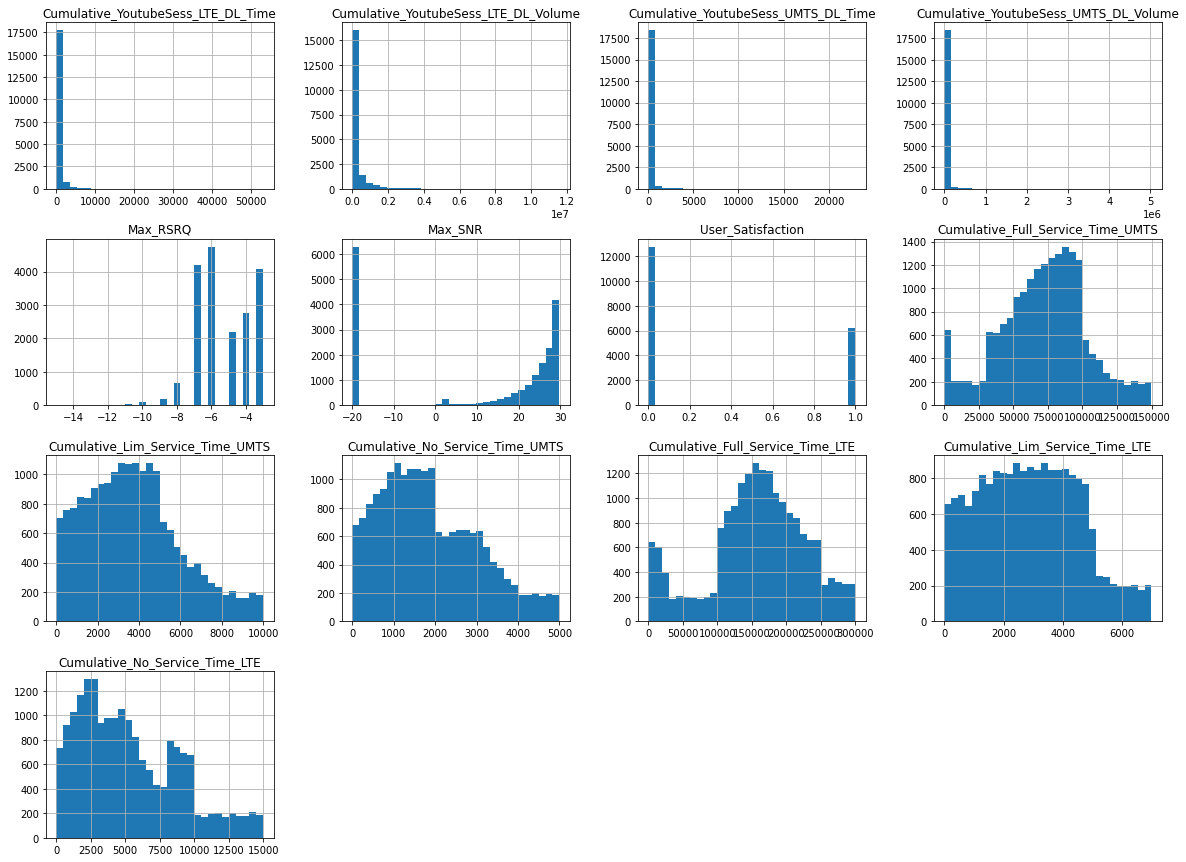

In [ ]:
basic_train.hist(bins=30, figsize=(20, 15))

In [ ]:
basic_train.describe()

,Cumulative_YoutubeSess_LTE_DL_Time,Cumulative_YoutubeSess_LTE_DL_Volume,Cumulative_YoutubeSess_UMTS_DL_Time,Cumulative_YoutubeSess_UMTS_DL_Volume,Max_RSRQ,Max_SNR,User_Satisfaction,Cumulative_Full_Service_Time_UMTS,Cumulative_Lim_Service_Time_UMTS,Cumulative_No_Service_Time_UMTS,Cumulative_Full_Service_Time_LTE,Cumulative_Lim_Service_Time_LTE,Cumulative_No_Service_Time_LTE
count,18970.000000,1.897000e+04,18970.000000,1.897000e+04,18970.000000,18970.000000,18970.000000,18970.000000,18970.000000,18970.000000,18970.000000,18970.000000,18970.000000
mean,487.266447,2.440304e+05,110.665139,2.232142e+04,-5.307433,9.883853,0.327464,72252.154296,3752.604006,1872.484555,158112.288508,2908.896679,5258.542910
std,1449.015098,6.374373e+05,624.233314,1.355857e+05,1.669185,21.491851,0.469301,31227.745075,2295.803530,1187.075427,70135.668569,1672.653145,3592.832064
min,0.000000,0.000000e+00,0.000000,0.000000e+00,-15.000000,-20.000000,0.000000,3.000000,1.000000,0.000000,40.000000,0.000000,0.000000
25%,11.369250,5.140000e+02,0.000000,0.000000e+00,-7.000000,-19.800000,0.000000,52438.250000,1974.000000,945.000000,120955.000000,1545.000000,2346.000000
50%,79.409000,3.361850e+04,0.000000,0.000000e+00,-6.000000,23.000000,0.000000,74205.000000,3552.000000,1677.000000,162095.500000,2864.000000,4579.000000
75%,370.633000,1.920348e+05,20.027750,2.370500e+03,-4.000000,27.800000,1.000000,92469.500000,5082.750000,2712.500000,206388.500000,4156.000000,8018.000000
max,53176.133000,1.158222e+07,22973.810000,5.024200e+06,-3.000000,29.800000,1.000000,149980.000000,9999.000000,4998.000000,299988.000000,6997.000000,14999.000000


# Features Engineering

In [ ]:
# Adding new features
basic_train['Total_YoutubeSess_DL_volume'] = basic_train['Cumulative_YoutubeSess_UMTS_DL_Volume']+basic_train['Cumulative_YoutubeSess_LTE_DL_Volume']
basic_train['Total_YoutubeSess_DL_Time'] = basic_train['Cumulative_YoutubeSess_UMTS_DL_Time']+basic_train['Cumulative_YoutubeSess_LTE_DL_Time']
basic_train['Average_Throughput'] = basic_train['Total_YoutubeSess_DL_volume'] / basic_train['Total_YoutubeSess_DL_Time']
Total_service_time_UMTS = basic_train['Cumulative_Full_Service_Time_UMTS']+basic_train['Cumulative_Lim_Service_Time_UMTS']+basic_train['Cumulative_No_Service_Time_UMTS']
Total_service_time_LTE = basic_train['Cumulative_Full_Service_Time_LTE']+basic_train['Cumulative_Lim_Service_Time_LTE']+basic_train['Cumulative_No_Service_Time_LTE']
Total_service_time = Total_service_time_UMTS + Total_service_time_LTE
basic_train['Proportion_Full_Service_Time'] = (basic_train['Cumulative_Full_Service_Time_UMTS']+basic_train['Cumulative_Full_Service_Time_LTE']) / Total_service_time
basic_train['Proportion_Lim_Service_Time'] = (basic_train['Cumulative_Lim_Service_Time_UMTS']+basic_train['Cumulative_Lim_Service_Time_LTE']) / Total_service_time
basic_train['Proportion_No_Service_Time'] = (basic_train['Cumulative_No_Service_Time_UMTS']+basic_train['Cumulative_No_Service_Time_LTE']) / Total_service_time
basic_train.head()

,Cumulative_YoutubeSess_LTE_DL_Time,Cumulative_YoutubeSess_LTE_DL_Volume,Cumulative_YoutubeSess_UMTS_DL_Time,Cumulative_YoutubeSess_UMTS_DL_Volume,Max_RSRQ,Max_SNR,User_Satisfaction,Cumulative_Full_Service_Time_UMTS,Cumulative_Lim_Service_Time_UMTS,Cumulative_No_Service_Time_UMTS,Cumulative_Full_Service_Time_LTE,Cumulative_Lim_Service_Time_LTE,Cumulative_No_Service_Time_LTE,Total_YoutubeSess_DL_volume,Total_YoutubeSess_DL_Time,Average_Throughput,Proportion_Full_Service_Time,Proportion_Lim_Service_Time,Proportion_No_Service_Time
0,100.727,110854.0,0.000,0.0,-6.0,27.8,1.0,53917,5636,2043,213227,3996,2883,110854.0,100.727,1100.539081,0.948321,0.034192,0.017487
1,9.324,93.0,0.000,0.0,-3.0,-19.8,0.0,85021,1761,1223,87700,4287,1251,93.0,9.324,9.974260,0.952980,0.033370,0.013650
2,2715.406,2271118.0,580.907,63891.0,-3.0,-19.8,0.0,123462,4664,2715,203846,5776,8748,2335009.0,3296.313,708.369927,0.937279,0.029896,0.032825
3,74.097,39065.0,0.000,0.0,-4.0,-19.8,0.0,85675,4903,1322,7924,1799,9491,39065.0,74.097,527.214327,0.842369,0.060316,0.097314
4,168.955,41933.0,0.000,0.0,-3.0,-19.9,1.0,104902,2068,669,137121,3846,937,41933.0,168.955,248.190347,0.969865,0.023699,0.006436


In [ ]:
# Feature values on average grouped by target class
basic_train.groupby('User_Satisfaction').mean()

,Cumulative_YoutubeSess_LTE_DL_Time,Cumulative_YoutubeSess_LTE_DL_Volume,Cumulative_YoutubeSess_UMTS_DL_Time,Cumulative_YoutubeSess_UMTS_DL_Volume,Max_RSRQ,Max_SNR,Cumulative_Full_Service_Time_UMTS,Cumulative_Lim_Service_Time_UMTS,Cumulative_No_Service_Time_UMTS,Cumulative_Full_Service_Time_LTE,Cumulative_Lim_Service_Time_LTE,Cumulative_No_Service_Time_LTE,Total_YoutubeSess_DL_volume,Total_YoutubeSess_DL_Time,Average_Throughput,Proportion_Full_Service_Time,Proportion_Lim_Service_Time,Proportion_No_Service_Time
User_Satisfaction,,,,,,,,,,,,,,,,,,
0.0,480.839776,249770.067252,109.838089,23059.840806,-5.264462,10.499859,75137.381486,3615.004389,1856.087475,161012.123530,2863.504468,5219.942624,272829.908058,590.677866,395.724489,0.937081,0.030240,0.032679
1.0,500.465330,232242.481326,112.363706,20804.880554,-5.395686,8.618722,66326.570187,4035.201545,1906.160335,152156.703316,3002.121700,5337.818899,253047.361880,612.829036,357.953758,0.927400,0.035568,0.037032


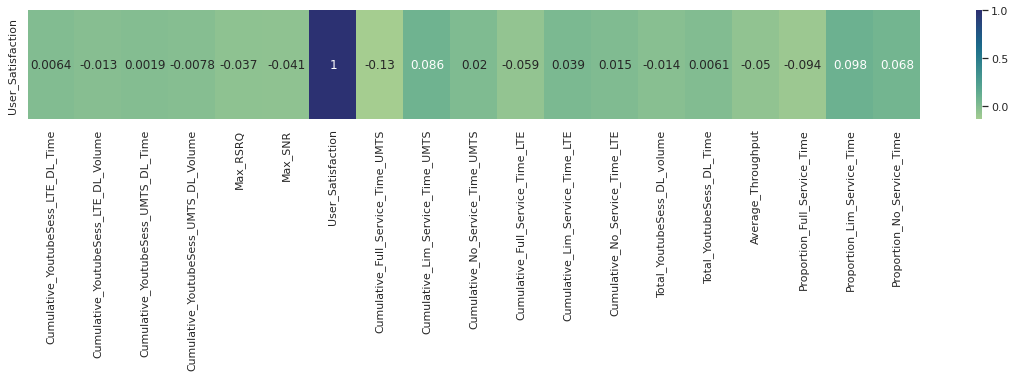

In [ ]:
# Correlation heatmap
sns.set(rc = {'figure.figsize':(20,2)})
sns.heatmap(basic_train.corr().loc[['User_Satisfaction'],:], annot = True, fmt='.2g',cmap= 'crest')

In [ ]:
# Top 6 postively correlated features
basic_train[basic_train.columns[1:]].corr()['User_Satisfaction'].sort_values(ascending=False)[:6]

User_Satisfaction                   1.000000
Proportion_Lim_Service_Time         0.098349
Cumulative_Lim_Service_Time_UMTS    0.085895
Proportion_No_Service_Time          0.068135
Cumulative_Lim_Service_Time_LTE     0.038892
Cumulative_No_Service_Time_UMTS     0.019796
Name: User_Satisfaction, dtype: float64

In [ ]:
# Top 6 negatively correlated features
basic_train[basic_train.columns[1:]].corr()['User_Satisfaction'].sort_values(ascending=True)[:6]

Cumulative_Full_Service_Time_UMTS   -0.132412
Proportion_Full_Service_Time        -0.093523
Cumulative_Full_Service_Time_LTE    -0.059255
Average_Throughput                  -0.049772
Max_SNR                             -0.041077
Max_RSRQ                            -0.036894
Name: User_Satisfaction, dtype: float64

In [ ]:
dataset = basic_train.drop(['User_Satisfaction'], axis=1)
ground_truth = basic_train.loc[:, 'User_Satisfaction'].copy()
print('Train Data:', dataset.shape)
print('Train Target:', ground_truth.shape)

Train Data: (18970, 18)
Train Target: (18970,)


In [ ]:
dataset.describe()

,Cumulative_YoutubeSess_LTE_DL_Time,Cumulative_YoutubeSess_LTE_DL_Volume,Cumulative_YoutubeSess_UMTS_DL_Time,Cumulative_YoutubeSess_UMTS_DL_Volume,Max_RSRQ,Max_SNR,Cumulative_Full_Service_Time_UMTS,Cumulative_Lim_Service_Time_UMTS,Cumulative_No_Service_Time_UMTS,Cumulative_Full_Service_Time_LTE,Cumulative_Lim_Service_Time_LTE,Cumulative_No_Service_Time_LTE,Total_YoutubeSess_DL_volume,Total_YoutubeSess_DL_Time,Average_Throughput,Proportion_Full_Service_Time,Proportion_Lim_Service_Time,Proportion_No_Service_Time
count,18970.000000,1.897000e+04,18970.000000,1.897000e+04,18970.000000,18970.000000,18970.000000,18970.000000,18970.000000,18970.000000,18970.000000,18970.000000,1.897000e+04,18970.000000,18970.000000,18970.000000,18970.000000,18970.000000
mean,487.266447,2.440304e+05,110.665139,2.232142e+04,-5.307433,9.883853,72252.154296,3752.604006,1872.484555,158112.288508,2908.896679,5258.542910,2.663518e+05,597.931586,383.355918,0.933911,0.031984,0.034105
std,1449.015098,6.374373e+05,624.233314,1.355857e+05,1.669185,21.491851,31227.745075,2295.803530,1187.075427,70135.668569,1672.653145,3592.832064,6.736381e+05,1715.953543,356.143763,0.048579,0.025425,0.029980
min,0.000000,0.000000e+00,0.000000,0.000000e+00,-15.000000,-20.000000,3.000000,1.000000,0.000000,40.000000,0.000000,0.000000,0.000000e+00,2.020000,0.000000,0.043129,0.000183,0.000208
25%,11.369250,5.140000e+02,0.000000,0.000000e+00,-7.000000,-19.800000,52438.250000,1974.000000,945.000000,120955.000000,1545.000000,2346.000000,2.561000e+03,17.484250,97.093075,0.923840,0.018272,0.017109
50%,79.409000,3.361850e+04,0.000000,0.000000e+00,-6.000000,23.000000,74205.000000,3552.000000,1677.000000,162095.500000,2864.000000,4579.000000,4.167850e+04,106.357000,324.039735,0.944918,0.026589,0.027561
75%,370.633000,1.920348e+05,20.027750,2.370500e+03,-4.000000,27.800000,92469.500000,5082.750000,2712.500000,206388.500000,4156.000000,8018.000000,2.178772e+05,475.467250,554.436759,0.959380,0.038043,0.042276
max,53176.133000,1.158222e+07,22973.810000,5.024200e+06,-3.000000,29.800000,149980.000000,9999.000000,4998.000000,299988.000000,6997.000000,14999.000000,1.443944e+07,63325.325000,4278.826185,0.994165,0.577503,0.596904


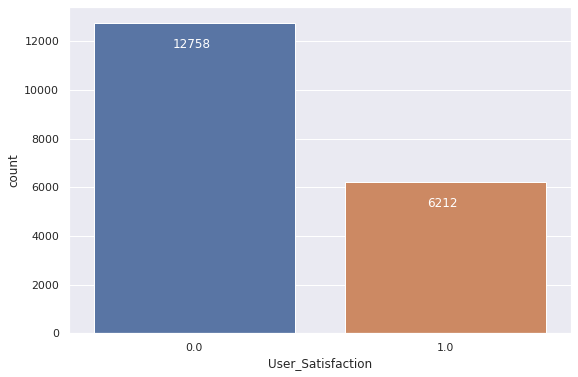

In [ ]:
# Target variable count
sns.set(rc = {'figure.figsize':(9,6)})
ax = sns.countplot(x=ground_truth, data=dataset)
for p in ax.patches:
        ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.39, p.get_height()), ha='center', va='top', color='white', size=12)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcd3dd22c90>,
      dtype=object)

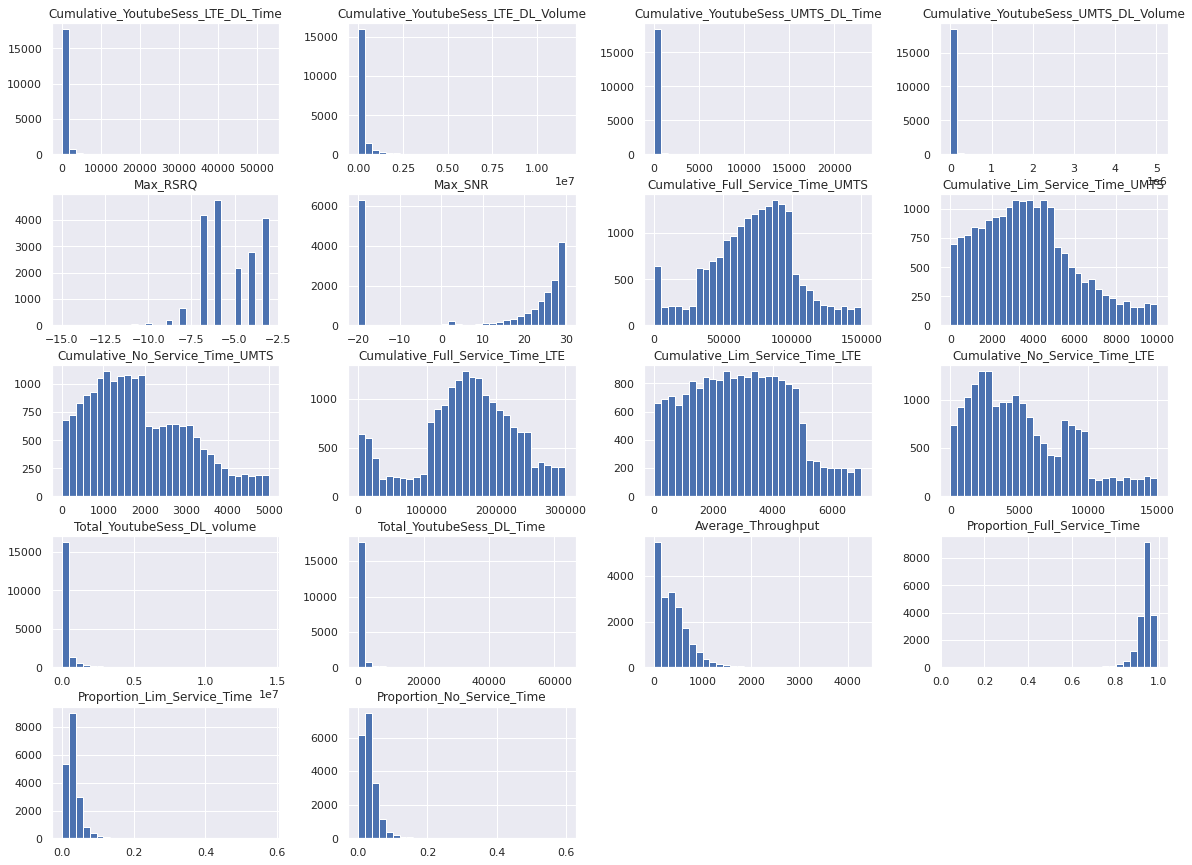

In [ ]:
# Visualize all features
dataset.hist(bins=30, figsize=(20, 15))
#plt.savefig('histogram_all_features.png', bbox_inches='tight')

In [ ]:
# Feature values on average grouped by User satisfaction
dataset.groupby(ground_truth).mean()

,Cumulative_YoutubeSess_LTE_DL_Time,Cumulative_YoutubeSess_LTE_DL_Volume,Cumulative_YoutubeSess_UMTS_DL_Time,Cumulative_YoutubeSess_UMTS_DL_Volume,Max_RSRQ,Max_SNR,Cumulative_Full_Service_Time_UMTS,Cumulative_Lim_Service_Time_UMTS,Cumulative_No_Service_Time_UMTS,Cumulative_Full_Service_Time_LTE,Cumulative_Lim_Service_Time_LTE,Cumulative_No_Service_Time_LTE,Total_YoutubeSess_DL_volume,Total_YoutubeSess_DL_Time,Average_Throughput,Proportion_Full_Service_Time,Proportion_Lim_Service_Time,Proportion_No_Service_Time
User_Satisfaction,,,,,,,,,,,,,,,,,,
0.0,480.839776,249770.067252,109.838089,23059.840806,-5.264462,10.499859,75137.381486,3615.004389,1856.087475,161012.123530,2863.504468,5219.942624,272829.908058,590.677866,395.724489,0.937081,0.030240,0.032679
1.0,500.465330,232242.481326,112.363706,20804.880554,-5.395686,8.618722,66326.570187,4035.201545,1906.160335,152156.703316,3002.121700,5337.818899,253047.361880,612.829036,357.953758,0.927400,0.035568,0.037032


# Prediction Pipeline

## Select ML Classifiers, HP Candidate Values and K-Fold Validation Structure

In [ ]:
# Choose k of K-Fold Validation Procedure
splits = 2

# Select ML Classifiers
names = ["Logistic Regression", "XGBoost"]
raw_classifiers = [LogisticRegression(penalty='l2', solver='lbfgs'), XGBClassifier()] #: LR model has 1 Hyper-Parameter, which is the
# regularisaton coefficient C. Its value should be tuned according to a K-Fold Validation Procedure.

# Choose Hyper-Parameters Candidate Values
parameters_grid = [{'C': [0.1,1,5]},
                   {"max_depth": [5, 8, 10], 'n_estimators': [100, 400, 900],
                     'reg_lambda': [0.1, 0.5, 1], 'gamma': [0, 0.5, 0.9], 'reg_alpha': [0, 0.5, 0.9],
                     "learning_rate": [0.1, 0.01, 0.05], 'colsample_bytree': [0.3, 0.7]}]# , ,  ,}]#LR: in this example a grid search is performed over a set of 3 candidate
                                        # values for hyper-parameter C


## Tune ML Classifiers through a K-Fold Validation

In [ ]:
X_train = dataset.copy()
## NORMALISE DATA
mean = dataset.mean(axis=0)
std = dataset.std(axis=0)
dataset = (dataset - mean) / std
dataset.dropna(inplace=True) #check data consistency

# Print Info
print(20*'*')
print('% of Class 1 in Training : ', len(ground_truth[ground_truth == 1]) / len(ground_truth),
      '; % of Class 0 in Training: ', len(ground_truth[ground_truth == 0]) / len(ground_truth))
print('Shape Training Set :', dataset.shape, ',', ground_truth.shape)
print(20*'*')

# Select Best Hyperparameter Value for This Fold
# Commented due to long run time, already executed multiple times to obtain hyperparameter values
#hp_values = hyperparameter_tuning(dataset, ground_truth, names,
#                      raw_classifiers, parameters_grid, n_splits_in=splits)

#hp_values.head()


********************
% of Class 1 in Training :  0.3274644175013179 ; % of Class 0 in Training:  0.6725355824986822
Shape Training Set : (18970, 18) , (18970,)
********************


## Evaluate Performance on Test Set, where each ML Classifier work with best HP Values

In [ ]:
# Import Test Data
basic_test = pd.read_csv(path+'BasicDataset_Test_MRN.csv')

# Add new features similar to training data
basic_test['Total_YoutubeSess_DL_volume'] = basic_test['Cumulative_YoutubeSess_UMTS_DL_Volume']+basic_test['Cumulative_YoutubeSess_LTE_DL_Volume']
basic_test['Total_YoutubeSess_DL_Time'] = basic_test['Cumulative_YoutubeSess_UMTS_DL_Time']+basic_test['Cumulative_YoutubeSess_LTE_DL_Time']
basic_test['Average_Throughput'] = (basic_test['Cumulative_YoutubeSess_UMTS_DL_Volume']+basic_test['Cumulative_YoutubeSess_LTE_DL_Volume']) / (basic_test['Cumulative_YoutubeSess_UMTS_DL_Time']+basic_test['Cumulative_YoutubeSess_LTE_DL_Time'])
Total_service_time_UMTS = basic_test['Cumulative_Full_Service_Time_UMTS']+basic_test['Cumulative_Lim_Service_Time_UMTS']+basic_test['Cumulative_No_Service_Time_UMTS']
Total_service_time_LTE = basic_test['Cumulative_Full_Service_Time_LTE']+basic_test['Cumulative_Lim_Service_Time_LTE']+basic_test['Cumulative_No_Service_Time_LTE']
Total_service_time = Total_service_time_UMTS + Total_service_time_LTE
basic_test['Proportion_Full_Service_Time'] = (basic_test['Cumulative_Full_Service_Time_UMTS']+basic_test['Cumulative_Full_Service_Time_LTE']) / Total_service_time
basic_test['Proportion_Lim_Service_Time'] = (basic_test['Cumulative_Lim_Service_Time_UMTS']+basic_test['Cumulative_Lim_Service_Time_LTE']) / Total_service_time
basic_test['Proportion_No_Service_Time'] = (basic_test['Cumulative_No_Service_Time_UMTS']+basic_test['Cumulative_No_Service_Time_LTE']) / Total_service_time

dataset_test = basic_test.drop(['User_Satisfaction','Unnamed: 0', 'Unnamed: 0.1'], axis=1)
ground_truth_test = basic_test.loc[:, 'User_Satisfaction'].copy()
print('Test Data:', dataset_test.shape)
print('Test Target:', ground_truth_test.shape)

Test Data: (4743, 18)
Test Target: (4743,)


In [ ]:
# Select ML Classifiers and Fix the HP Values to the best values found in previous iteration of the pipeline
names = ["Logistic Regression", "XGBoost"]
# Commented due to long run time, already executed multiple times to obtain hyperparameter values
#reg_coeff = hp_values.loc["Logistic Regression","BestHP_Values"][0]
#n_estimators = hp_values.loc["XGBoost","BestHP_Values"][3]
#learning_rate = hp_values.loc["XGBoost","BestHP_Values"][1]
#max_depth = hp_values.loc["XGBoost","BestHP_Values"][2]
#colsample_bytree = hp_values.loc["XGBoost","BestHP_Values"][0]
#max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators, colsample_bytree=colsample_bytree
classifiers = [LogisticRegression(C = 0.1, penalty='l2', solver='lbfgs'),
               XGBClassifier(max_depth=8, learning_rate=0.01, n_estimators=400, colsample_bytree=0.7, reg_alpha=0.9, gamma=0.9)]

X_test = dataset_test.copy()
## NORMALISE DATA (Always with refer to Train Data)
dataset_test = (dataset_test - mean) / std
dataset_test.dropna(inplace=True) #check data consistency

# Print Info
print(20*'*')
print('% of Class 1 in Testing : ', len(ground_truth_test[ground_truth_test == 1]) / len(ground_truth_test),
      '; % of Class 0 in Testing: ', len(ground_truth_test[ground_truth_test == 0]) / len(ground_truth_test))
print('Shape Test Set :', dataset_test.shape, ',', ground_truth_test.shape)
print(20*'*')



********************
% of Class 1 in Testing :  0.32089394897744045 ; % of Class 0 in Testing:  0.6791060510225596
Shape Test Set : (4743, 18) , (4743,)
********************


 Classifier Logistic Regression - Fit & Predict
 Classifier XGBoost - Fit & Predict


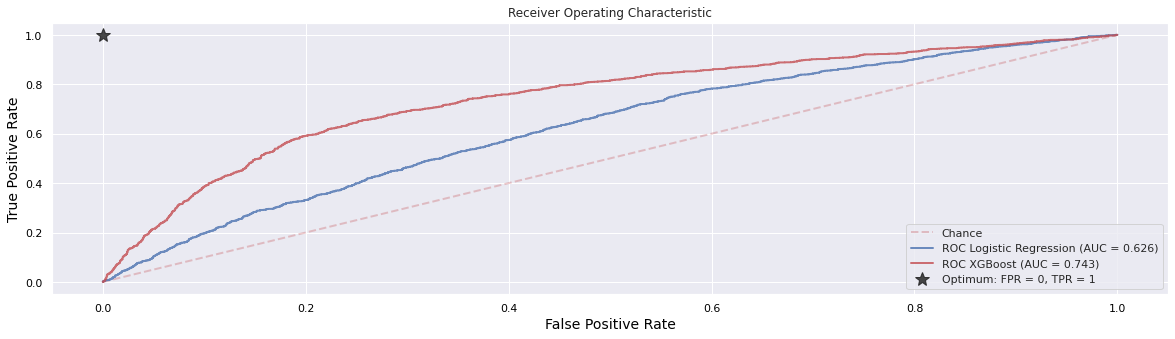

,AUC
Logistic Regression,0.625886
XGBoost,0.74261


In [ ]:
# Print Performance on Test Set
performance, predictions = direct_prediction(dataset, ground_truth,
                                dataset_test, ground_truth_test,
                                names, classifiers)

performance.head()

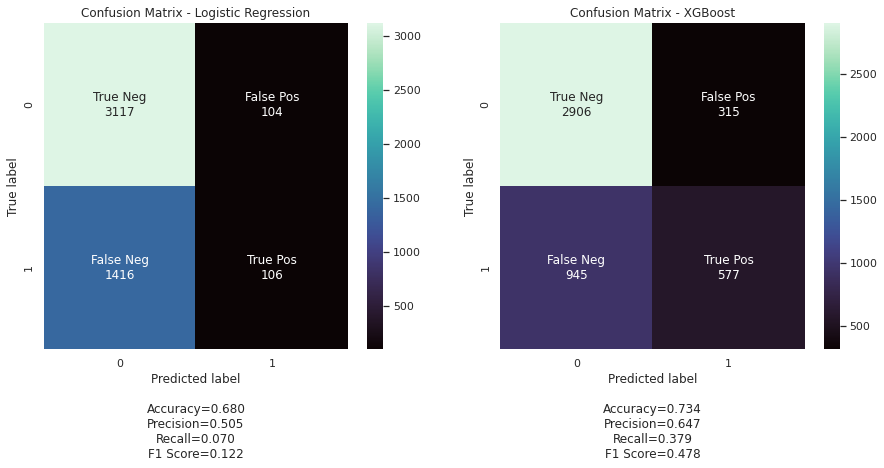

In [ ]:
# Plot Confusion Matrix
plot_cf_matrix(dataset, ground_truth, dataset_test, ground_truth_test, predictions, names)

In [ ]:
# Oversampling training set
from imblearn.over_sampling import SMOTE

os = SMOTE(random_state=0)
columns = dataset.columns
os_data_X, os_data_y = os.fit_resample(X_train, ground_truth)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
print('Oversampled Train Data:', os_data_X.shape)
print('Oversampled Train Target:', os_data_y.shape)

Oversampled Train Data: (25516, 18)
Oversampled Train Target: (25516,)


In [ ]:
os_data_X.groupby(os_data_y).mean()

,Cumulative_YoutubeSess_LTE_DL_Time,Cumulative_YoutubeSess_LTE_DL_Volume,Cumulative_YoutubeSess_UMTS_DL_Time,Cumulative_YoutubeSess_UMTS_DL_Volume,Max_RSRQ,Max_SNR,Cumulative_Full_Service_Time_UMTS,Cumulative_Lim_Service_Time_UMTS,Cumulative_No_Service_Time_UMTS,Cumulative_Full_Service_Time_LTE,Cumulative_Lim_Service_Time_LTE,Cumulative_No_Service_Time_LTE,Total_YoutubeSess_DL_volume,Total_YoutubeSess_DL_Time,Average_Throughput,Proportion_Full_Service_Time,Proportion_Lim_Service_Time,Proportion_No_Service_Time
User_Satisfaction,,,,,,,,,,,,,,,,,,
0.0,480.839776,249770.067252,109.838089,23059.840806,-5.264462,10.499859,75137.381486,3615.004389,1856.087475,161012.123530,2863.504468,5219.942624,272829.908058,590.677866,395.724489,0.937081,0.030240,0.032679
1.0,519.283595,239154.251478,108.340733,19646.904237,-5.392764,8.411980,66203.961044,4028.182787,1906.267754,152520.645948,3004.732560,5296.808042,258801.155715,627.624327,357.768430,0.927922,0.035395,0.036683


In [ ]:
## NORMALISE DATA
mean = os_data_X.mean(axis=0)
std = os_data_X.std(axis=0)
os_data_X = (os_data_X - mean) / std
os_data_X.dropna(inplace=True)
## NORMALISE DATA (Always with refer to Train Data)
X_test = (X_test - mean) / std
X_test.dropna(inplace=True)

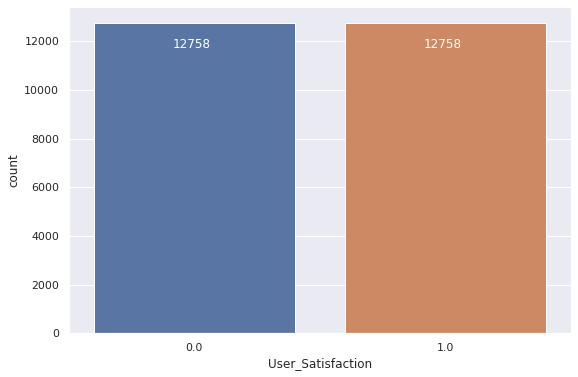

In [ ]:
# Target variable count
sns.set(rc = {'figure.figsize':(9,6)})
ax = sns.countplot(x=os_data_y, data=os_data_X)
for p in ax.patches:
        ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.39, p.get_height()), ha='center', va='top', color='white', size=12)

 Classifier Logistic Regression - Fit & Predict
 Classifier XGBoost - Fit & Predict


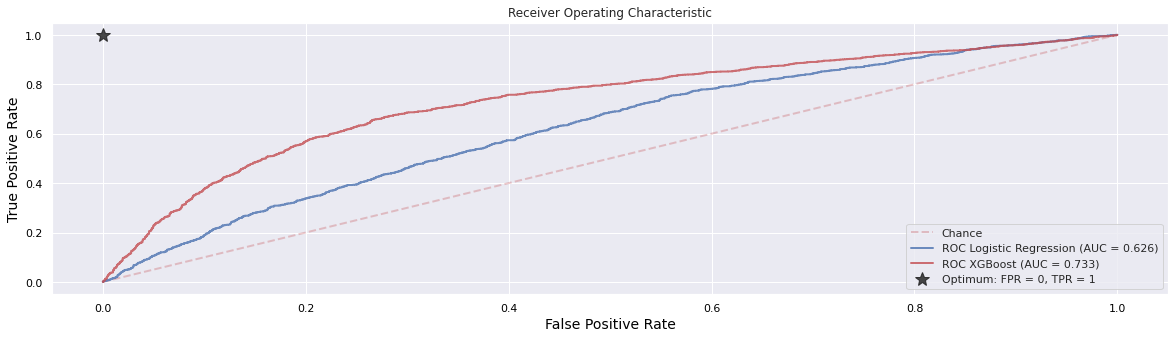

,AUC
Logistic Regression,0.625818
XGBoost,0.732954


In [ ]:
# Predict on test data
performance, predictions = direct_prediction(os_data_X, os_data_y,
                                X_test, ground_truth_test,
                                names, classifiers)

performance.head()